## Classifying names with a character-level RNN

### Read data

In [1]:
from __future__ import unicode_literals, division
# __future__의 목적: 언어에 호환되지 않는 변경이 도입된 미래 버전의 파이썬으로 옮겨가는 것을 쉽게하기 위함
from io import open
import glob # 입력 패턴을 따르는 경로탐색을 위한 모듈
import os

In [2]:
print(f"Data list:\n{glob.glob('data/names/*.txt')}")

Data list:
['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [4]:
def unicodeToAscii(s):
    return ''.join(\
                  c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn'
                  and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [5]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(category)
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

Arabic
Chinese
Czech
Dutch
English
French
German
Greek
Irish
Italian
Japanese
Korean
Polish
Portuguese
Russian
Scottish
Spanish
Vietnamese


### Turning names into tensors

In [6]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

### Creating the network

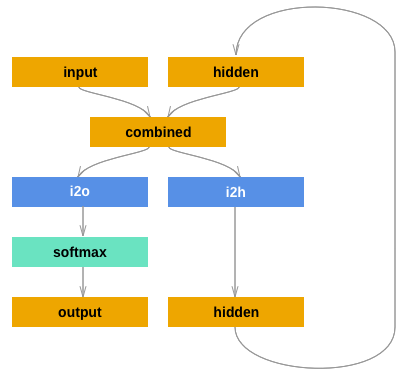

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '\ line =', line)

category = German \ line = Michel
category = Arabic \ line = Asker
category = Greek \ line = Close
category = Irish \ line = Giolla
category = Portuguese \ line = Soares
category = German \ line = Wildgrube
category = Dutch \ line = Kool
category = Spanish \ line = Jimenez
category = German \ line = Giehl
category = Irish \ line = Nevin


### Training the network

In [10]:
criterion = nn.NLLLoss()
learning_rate = 5e-3
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()
    

In [11]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds'%(m, s)

start = time.time()

for _iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if _iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'O' if guess == category else 'X (%s)'%category
        print('%d %d%% (%s) %.4f %s / %s %s' % (_iter, _iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    
    if _iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.9524 Magalhaes / Greek X (Portuguese)
10000 10% (0m 14s) 3.5328 Mata / Japanese X (Portuguese)
15000 15% (0m 21s) 1.8966 Janca / Czech O
20000 20% (0m 29s) 3.6333 Gavril / French X (Greek)
25000 25% (0m 37s) 1.6123 Berger / German X (French)
30000 30% (0m 50s) 0.8007 Czajka / Polish O
35000 35% (1m 3s) 2.5220 Rick / Czech X (English)
40000 40% (1m 18s) 2.2380 Knappett / German X (English)
45000 45% (1m 31s) 0.3391 Kachnov / Russian O
50000 50% (1m 46s) 0.6294 O'Donnell / Irish O
55000 55% (2m 2s) 3.4326 Viteri / Italian X (Spanish)
60000 60% (2m 18s) 0.4130 Ferro / Portuguese O
65000 65% (2m 34s) 0.9480 Gavrilopoulos / Chinese X (Greek)
70000 70% (2m 50s) 1.7062 Foth / German O
75000 75% (3m 5s) 0.5360 Christie / Scottish O
80000 80% (3m 21s) 1.6457 Masi / Japanese X (Italian)
85000 85% (3m 37s) 1.1898 Zimin / Russian O
90000 90% (3m 54s) 0.0211 Baldinotti / Italian O
95000 95% (4m 7s) 2.4744 Brodeur / German X (French)
100000 100% (4m 20s) 1.2976 Franco / Portuguese 

In [16]:
torch.save(rnn, "model/NLP_name_classifier.model")

C:\Users\sjpark\Anaconda3\envs\torch\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


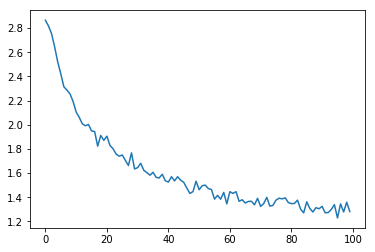

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
a
plt.figure()
plt.plot(all_losses)

### Evaluation with confusion matrix

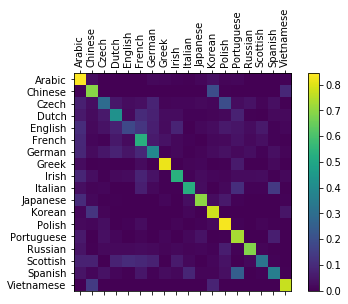

In [13]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [14]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.67) Russian
(-1.32) Czech
(-2.16) Polish

> Jackson
(-0.78) English
(-1.46) Scottish
(-2.01) Russian

> Satoshi
(-1.46) Japanese
(-1.68) Polish
(-1.80) Portuguese
